# OSIC Dataset Analysis

This notebook explores the OSIC (Open Source Imaging Consortium) dataset, analyzing both Clinical Research Form (CRF) data and DICOM imaging metadata.

In [1]:
# Install required packages
!pip install pandas seaborn matplotlib plotly networkx tabulate

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
import os
from datetime import datetime
from collections import Counter, defaultdict

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

/home/pansurya/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## 1. Data Loading and Preprocessing

### 1.1 Loading and Merging CRF Data

In [3]:
# Load and merge CRF files
crf_files = [
    '../../../scratch/bds/OSIC/CRF_FORM.csv',
    '../../../scratch/bds/OSIC/CRF_FORM_1.csv',
    '../../../scratch/bds/OSIC/CRF_FORM_2.csv',
    '../../../scratch/bds/OSIC/CRF_FORM_3.csv'
]

crf_dataframes = [pd.read_csv(file) for file in crf_files]
concatenated_df = pd.concat(crf_dataframes, ignore_index=True).reset_index(drop=True)

# Save merged data
concatenated_df.to_csv('../../../scratch/bds/OSIC/Merge_CRF_Form.csv', index=False)

print(f"Merged CRF data shape: {concatenated_df.shape}")
print(f"Total unique patients: {concatenated_df['Subject ID'].nunique()}")

PermissionError: [Errno 13] Permission denied: '../../../scratch/bds/OSIC/Merge_CRF_Form.csv'

### 1.2 Data Quality Assessment

In [4]:
def analyze_missing_data(df, threshold=67):
    """Analyze missing data patterns and filter features."""
    nan_percent = df.isna().mean() * 100
    
    # Features with high missing data
    high_nan_features = nan_percent[nan_percent > threshold].index.tolist()
    
    print(f"Original feature count: {df.shape[1]}")
    print(f"Features with >{threshold}% missing data: {len(high_nan_features)}")
    print(f"Remaining features after filtering: {df.shape[1] - len(high_nan_features)}")
    
    return df.drop(columns=high_nan_features), nan_percent

# Analyze and filter missing data
filtered_df, nan_percent = analyze_missing_data(concatenated_df)

Original feature count: 100
Features with >67% missing data: 69
Remaining features after filtering: 31


In [5]:
# Data cleaning: Forward/backward fill for categorical variables
cols_to_fill = ['Ethnicity', 'Race', 'Home Region', 'Sex', 'Research : Height', 
                'Cause of Death', 'Deceased', 'Primary Diagnosis','Secondary Diagnosis', 'Smoking History', 'Smoking Stop Date', 'Smoking Pack Years']

for col in cols_to_fill:
    if col in concatenated_df.columns:
        concatenated_df[col] = concatenated_df.groupby('Subject ID')[col].transform(
            lambda x: x.ffill().bfill()
        )

print("Missing data after cleaning:")
print(concatenated_df[cols_to_fill].isna().sum())

concatenated_df.to_csv('../../../scratch/bds/OSIC/Merge_CRF_fill.csv', index=False)




/tmp/ipykernel_1496662/2447345335.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.ffill().bfill()


Missing data after cleaning:
Ethnicity                267
Race                     267
Home Region                0
Sex                        0
Research : Height        331
Cause of Death         12047
Deceased                   0
Primary Diagnosis          0
Secondary Diagnosis    13004
Smoking History          340
Smoking Stop Date      10657
Smoking Pack Years      9656
dtype: int64


PermissionError: [Errno 13] Permission denied: '../../../scratch/bds/OSIC/Merge_CRF_fill.csv'

## 2. Demographics and Clinical Characteristics

### 2.1 Basic Demographics

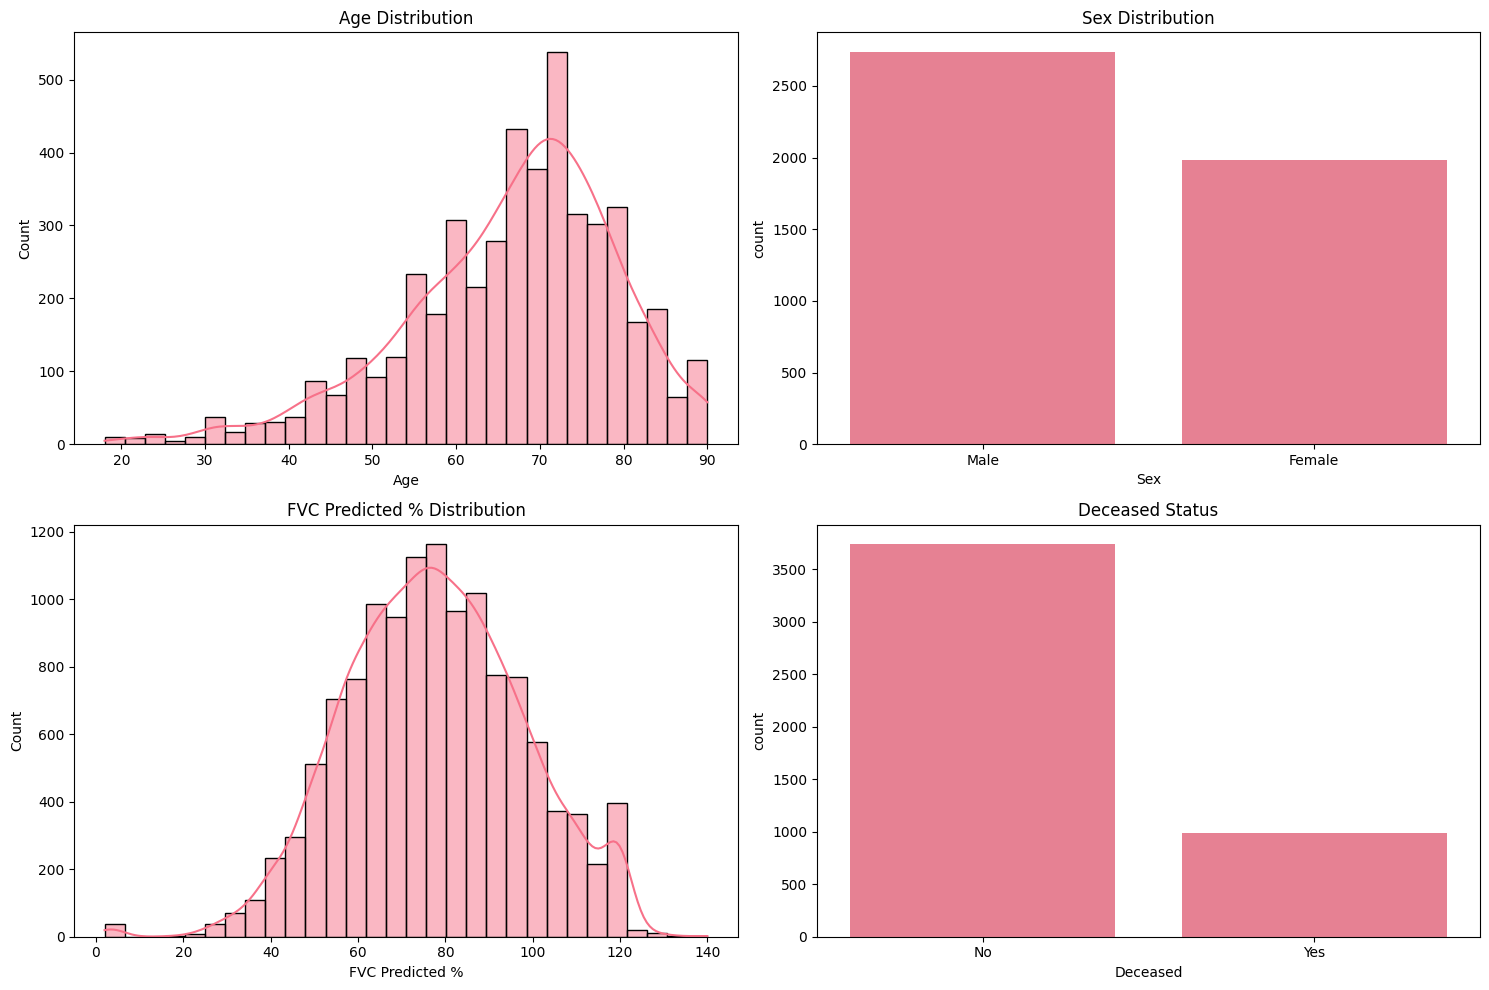

In [10]:
# Prepare visualization dataframe
viz_df = filtered_df.copy()
viz_df['Age'] = viz_df['Age'].replace('>89', 90).astype(float)

# Create demographic visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
sns.histplot(viz_df['Age'].dropna(), bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Age Distribution')

# Sex distribution
sns.countplot(data=viz_df, x='Sex', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')

# FVC Predicted % distribution
sns.histplot(viz_df['FVC Predicted %'].dropna(), bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('FVC Predicted % Distribution')

# Deceased status
sns.countplot(data=viz_df, x='Deceased', ax=axes[1,1])
axes[1,1].set_title('Deceased Status')

plt.tight_layout()
plt.show()

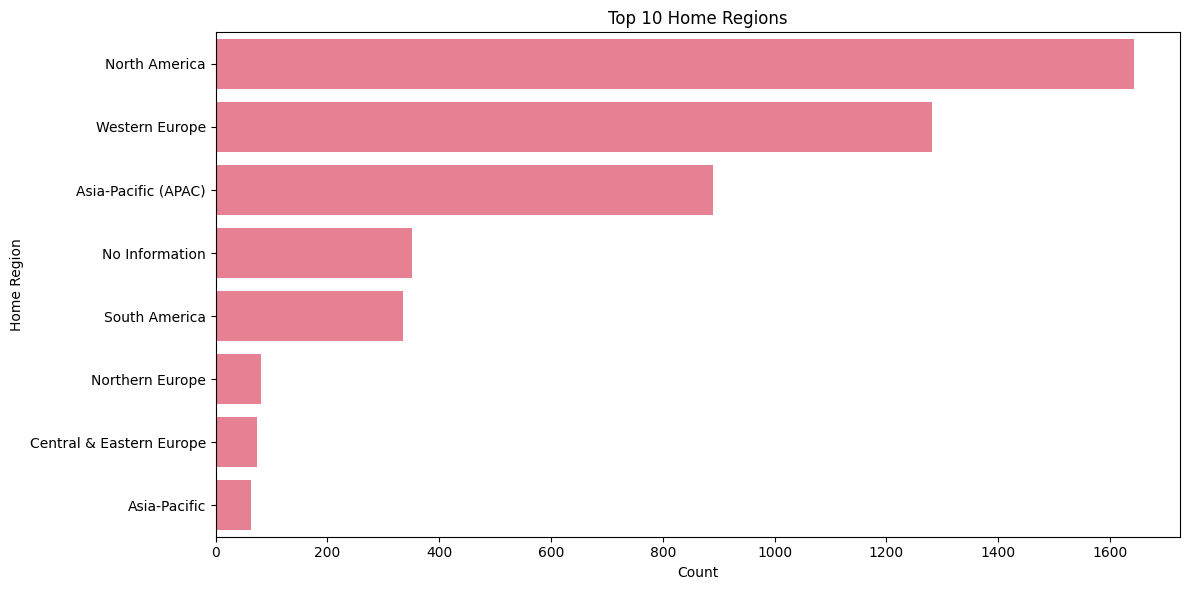

In [12]:
# Top 10 home regions
plt.figure(figsize=(12, 6))
top_regions = viz_df['Home Region'].value_counts().nlargest(10)
sns.barplot(x=top_regions.values, y=top_regions.index)
plt.title('Top 10 Home Regions')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

### 2.2 Gender-based Analysis

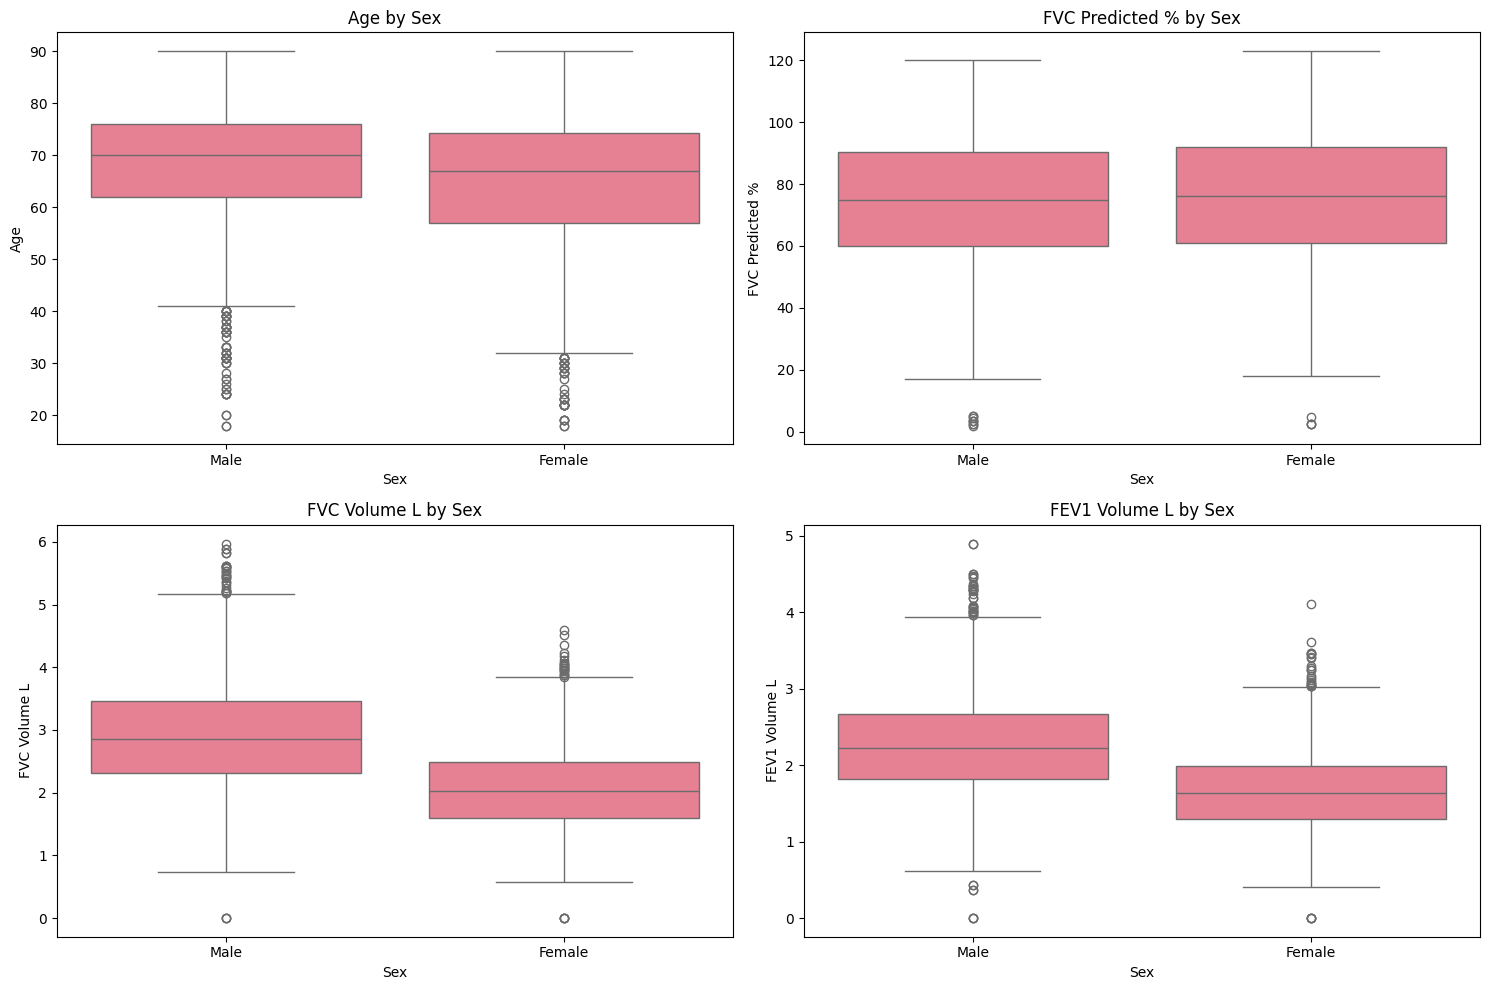

In [14]:
# Gender comparison for key metrics
features_to_compare = ['Age', 'FVC Predicted %', 'FVC Volume L', 'FEV1 Volume L']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features_to_compare):
    sns.boxplot(data=viz_df, x='Sex', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Sex')

plt.tight_layout()
plt.show()

## 3. Diagnosis Analysis

### 3.1 Primary Diagnosis Distribution

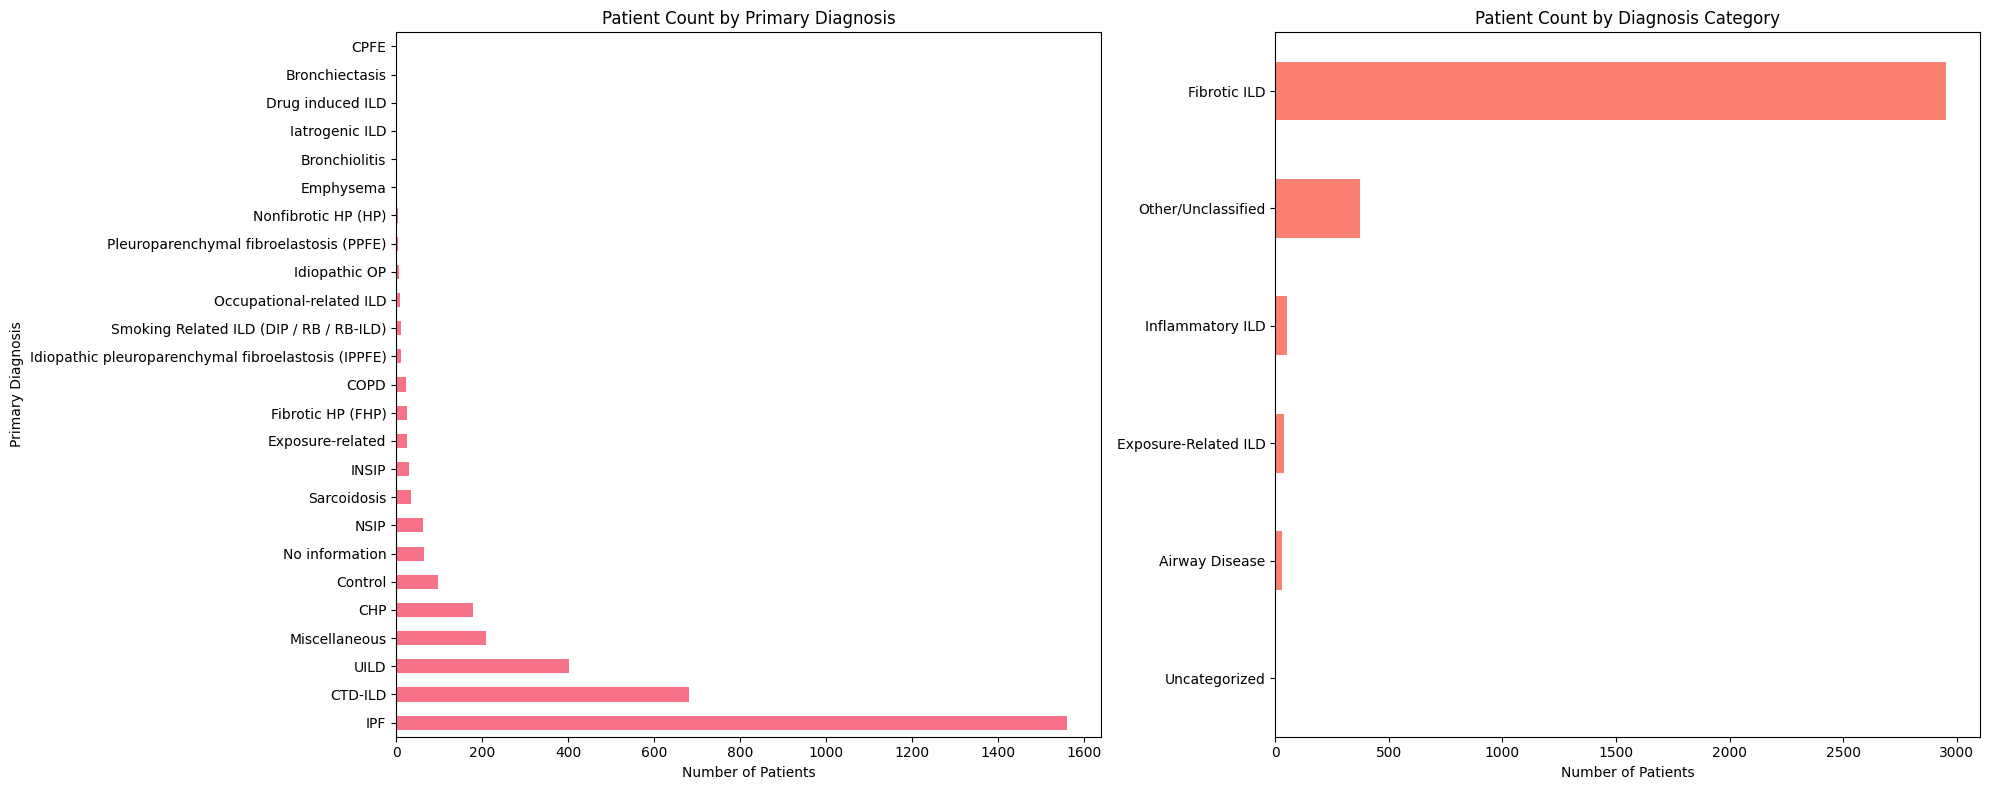

In [15]:
# Analyze diagnosis patterns
diagnosis_df = concatenated_df[['Subject ID', 'Primary Diagnosis']].dropna()
diagnosis_freq = diagnosis_df.groupby('Primary Diagnosis')['Subject ID'].nunique().sort_values(ascending=False)

# Diagnosis categories
diagnosis_categories = {
    'Airway Disease': ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Emphysema'],
    'Fibrotic ILD': ['IPF', 'NSIP', 'INSIP', 'Fibrotic HP (FHP)', 'CHP', 'CTD-ILD', 'CPFE',
                     'Pleuroparenchymal fibroelastosis (PPFE)', 'Idiopathic pleuroparenchymal fibroelastosis (IPPFE)', 'UILD'],
    'Inflammatory ILD': ['Idiopathic OP', 'Sarcoidosis', 'Smoking Related ILD (DIP / RB / RB-ILD)'],
    'Exposure-Related ILD': ['Occupational-related ILD', 'Exposure-related', 'Drug induced ILD', 'Iatrogenic ILD'],
    'Other/Unclassified': ['Miscellaneous', 'Control', 'No information']
}

# Categorize diagnoses
category_counts = defaultdict(int)
for diag, count in diagnosis_freq.items():
    found = False
    for category, diag_list in diagnosis_categories.items():
        if diag in diag_list:
            category_counts[category] += count
            found = True
            break
    if not found:
        category_counts['Uncategorized'] += count

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Individual diagnoses
diagnosis_freq.plot(kind='barh', ax=ax1)
ax1.set_title('Patient Count by Primary Diagnosis')
ax1.set_xlabel('Number of Patients')

# Diagnosis categories
pd.Series(category_counts).sort_values().plot(kind='barh', ax=ax2, color='salmon')
ax2.set_title('Patient Count by Diagnosis Category')
ax2.set_xlabel('Number of Patients')

plt.tight_layout()
plt.show()

## 4. DICOM Imaging Data Analysis

### 4.1 Loading DICOM Metadata

In [16]:
# Load and merge DICOM metadata
base_dir = '../../../scratch/bds/OSIC/'
df_list = []

for root, dirs, files in os.walk(base_dir):
    if 'DICOM_info.csv' in files:
        file_path = os.path.join(root, 'DICOM_info.csv')
        try:
            df = pd.read_csv(file_path)
            df['source_path'] = root
            df_list.append(df)
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"Merged DICOM DataFrame shape: {merged_df.shape}")
    print(f"Total DICOM files: {len(df_list)}")
else:
    print("No DICOM_info.csv files found.")

KeyboardInterrupt: 

### 4.2 DICOM Technical Parameters

In [ ]:
# Analyze imaging parameters
technical_params = {
    'Manufacturer': len(set(merged_df['Manufacturer'])),
    'Model': len(set(merged_df['Model'])),
    'Algorithm': len(set(merged_df['Algorithm'])),
    'Thickness (mm)': len(set(merged_df['Thickness (mm)'])),
    'Interval (mm)': len(set(merged_df['Interval (mm)']))
}

print("Technical Parameter Diversity:")
for param, count in technical_params.items():
    print(f"  {param}: {count} unique values")

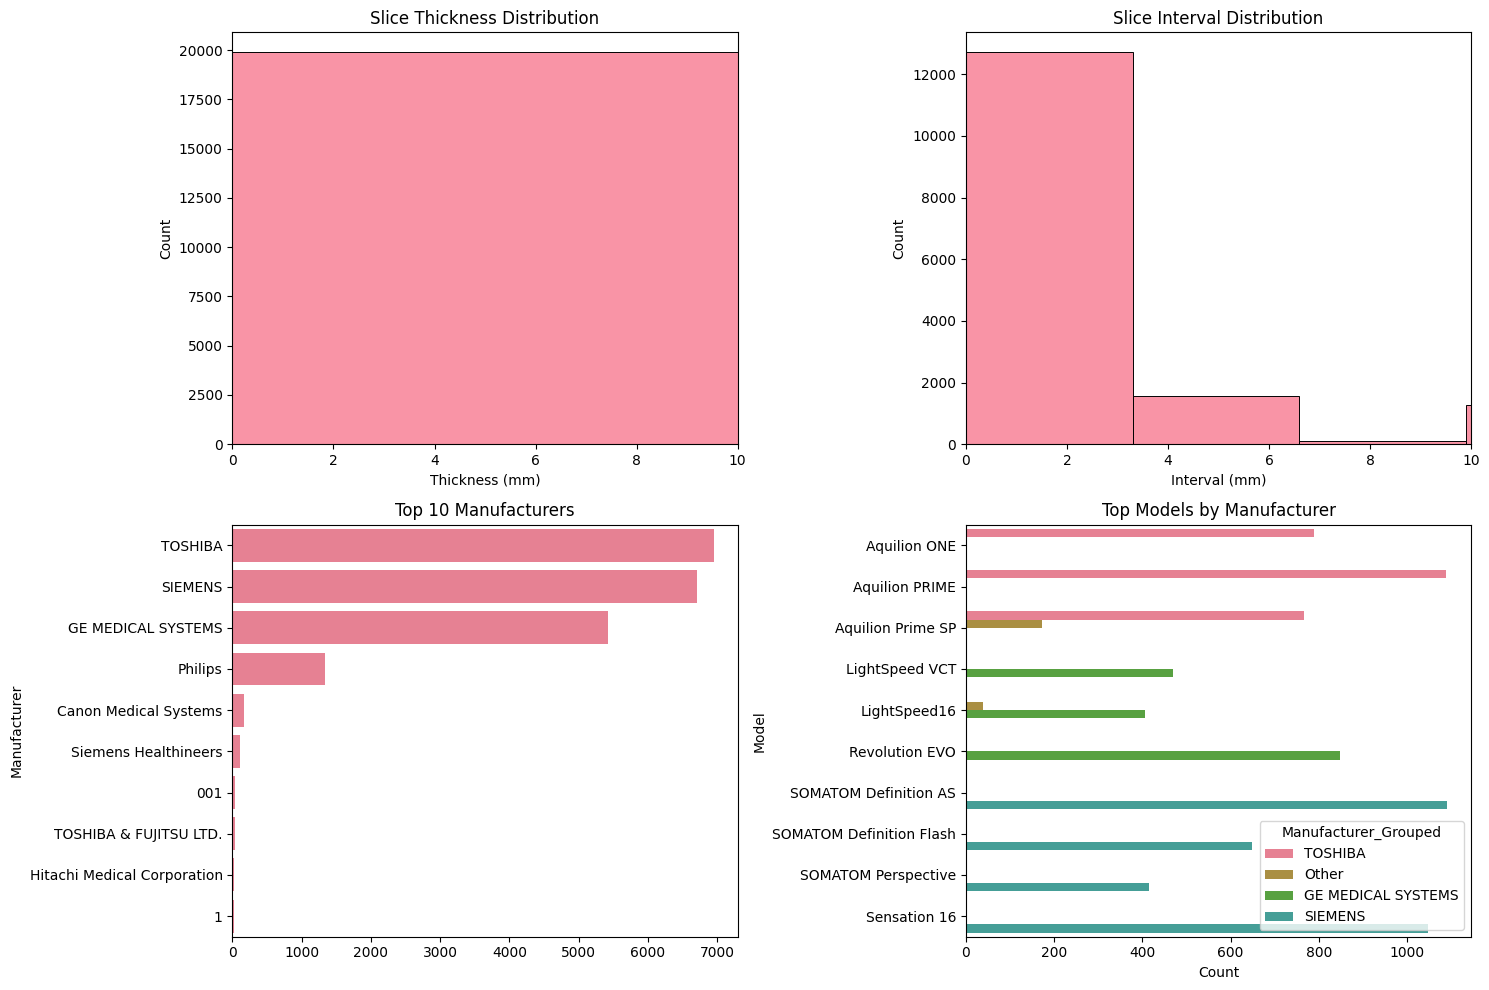

In [12]:
# Visualize key technical parameters
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Slice thickness distribution
sns.histplot(merged_df['Thickness (mm)'].dropna(), bins=50, ax=axes[0,0])
axes[0,0].set_title('Slice Thickness Distribution')
axes[0,0].set_xlim(0, 10)

# Slice interval distribution
sns.histplot(merged_df['Interval (mm)'].dropna(), bins=50, ax=axes[0,1])
axes[0,1].set_title('Slice Interval Distribution')
axes[0,1].set_xlim(0, 10)

# Manufacturer distribution
top_manufacturers = merged_df['Manufacturer'].value_counts().head(10)
sns.barplot(x=top_manufacturers.values, y=top_manufacturers.index, ax=axes[1,0])
axes[1,0].set_title('Top 10 Manufacturers')

# Model distribution (top manufacturers)
top4_manufacturers = merged_df['Manufacturer'].value_counts().nlargest(4).index
merged_df['Manufacturer_Grouped'] = merged_df['Manufacturer'].apply(
    lambda x: x if x in top4_manufacturers else 'Other'
)
model_counts = merged_df.groupby(['Model', 'Manufacturer_Grouped']).size().reset_index(name='Count')
top_models = model_counts.groupby('Model')['Count'].sum().sort_values(ascending=False).head(10).index
plot_df = model_counts[model_counts['Model'].isin(top_models)]

sns.barplot(data=plot_df, x='Count', y='Model', hue='Manufacturer_Grouped', ax=axes[1,1])
axes[1,1].set_title('Top Models by Manufacturer')

plt.tight_layout()
plt.show()

## 5. Longitudinal FVC Analysis

### 5.1 FVC Measurement Patterns

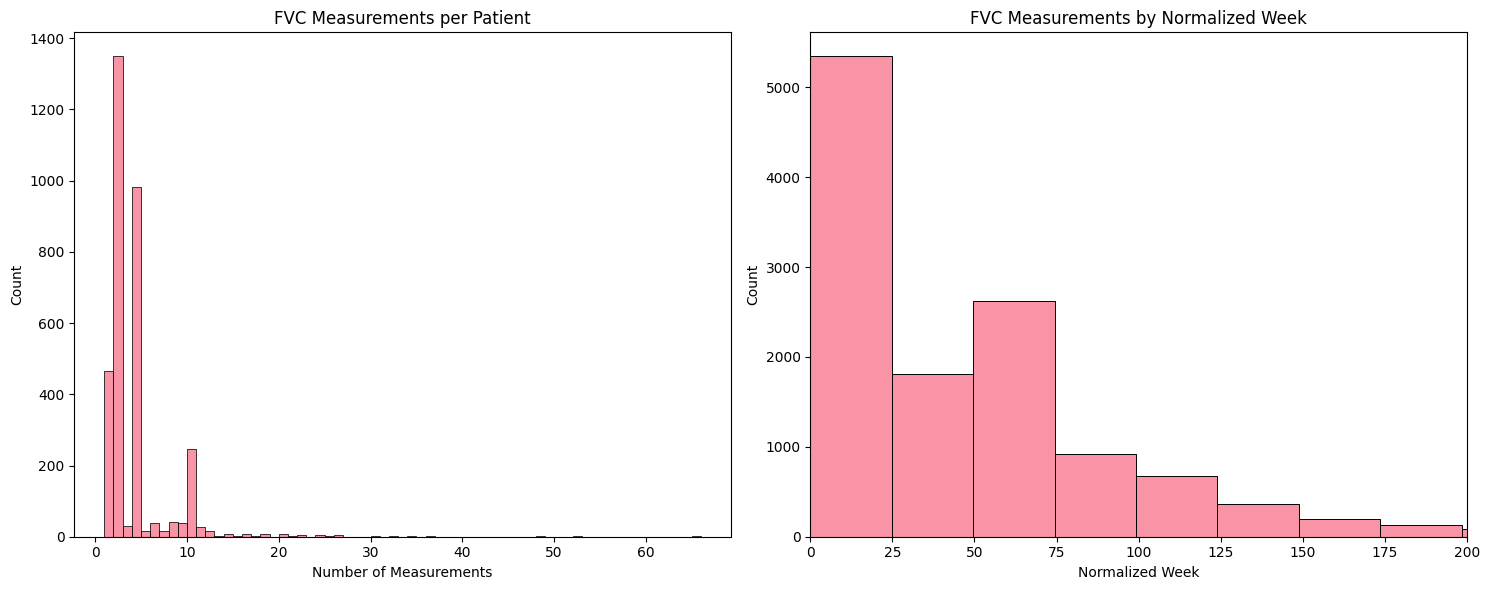

In [13]:
# Prepare FVC longitudinal data
df_fvc = concatenated_df.dropna(subset=['Subject ID', 'Week of FVC DATE', 'FVC Predicted %']).copy()
df_fvc['Week'] = df_fvc['Week of FVC DATE'].round().astype(int)
df_fvc['Normalized Week'] = df_fvc.groupby('Subject ID')['Week'].transform(lambda x: x - x.min())

# Analyze measurement frequency
measure_counts = [
    len(concatenated_df[concatenated_df['Subject ID'] == patient]['Week of FVC DATE'].dropna()) 
    for patient in concatenated_df['Subject ID'].unique()
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Measurement frequency per patient
sns.histplot(measure_counts, bins=range(1, max(measure_counts)+2), ax=ax1)
ax1.set_title('FVC Measurements per Patient')
ax1.set_xlabel('Number of Measurements')

# Distribution of measurements over normalized time
sns.histplot(df_fvc['Normalized Week'], bins=50, ax=ax2)
ax2.set_title('FVC Measurements by Normalized Week')
ax2.set_xlabel('Normalized Week')
ax2.set_xlim(0, 200)

plt.tight_layout()
plt.show()

### 5.2 FVC Decline Analysis

In [14]:
def classify_fvc_change(baseline, followup):
    """Classify FVC change as decline, stable, or improvement."""
    change = (followup - baseline) / baseline * 100
    if change <= -10:
        return 'Severe Decline (≥10%)'
    elif -10 < change < 0:
        return 'Mild Decline (0-10%)'
    elif change > 0:
        return 'Improvement (>0%)'
    else:
        return 'No Change'

# Analyze FVC changes over different time windows
follow_up_windows = {
    'Early (8-20 weeks)': (8, 20),
    'Mid (20-30 weeks)': (20, 30),
    'Late (40-70 weeks)': (40, 70)
}

results = {}
for label, (start, end) in follow_up_windows.items():
    counts = {'Severe Decline (≥10%)': 0, 'Mild Decline (0-10%)': 0, 'Improvement (>0%)': 0}
    
    for subject_id, group in df_fvc.groupby('Subject ID'):
        group = group.sort_values('Normalized Week')
        if len(group) < 2:
            continue
            
        baseline = group.iloc[0]['FVC Predicted %']
        followup = group[(group['Normalized Week'] >= start) & (group['Normalized Week'] <= end)]
        
        if not followup.empty:
            followup_fvc = followup.iloc[0]['FVC Predicted %']
            category = classify_fvc_change(baseline, followup_fvc)
            if category in counts:
                counts[category] += 1
    
    results[label] = counts

# Display results
print("FVC Change Analysis by Follow-up Period:")
for period, counts in results.items():
    print(f"\n{period}:")
    for category, count in counts.items():
        print(f"  {category}: {count} patients")

FVC Change Analysis by Follow-up Period:

Early (8-20 weeks):
  Severe Decline (≥10%): 57 patients
  Mild Decline (0-10%): 210 patients
  Improvement (>0%): 153 patients

Mid (20-30 weeks):
  Severe Decline (≥10%): 92 patients
  Mild Decline (0-10%): 188 patients
  Improvement (>0%): 126 patients

Late (40-70 weeks):
  Severe Decline (≥10%): 447 patients
  Mild Decline (0-10%): 662 patients
  Improvement (>0%): 680 patients


### 5.3 Longitudinal FVC Trajectories

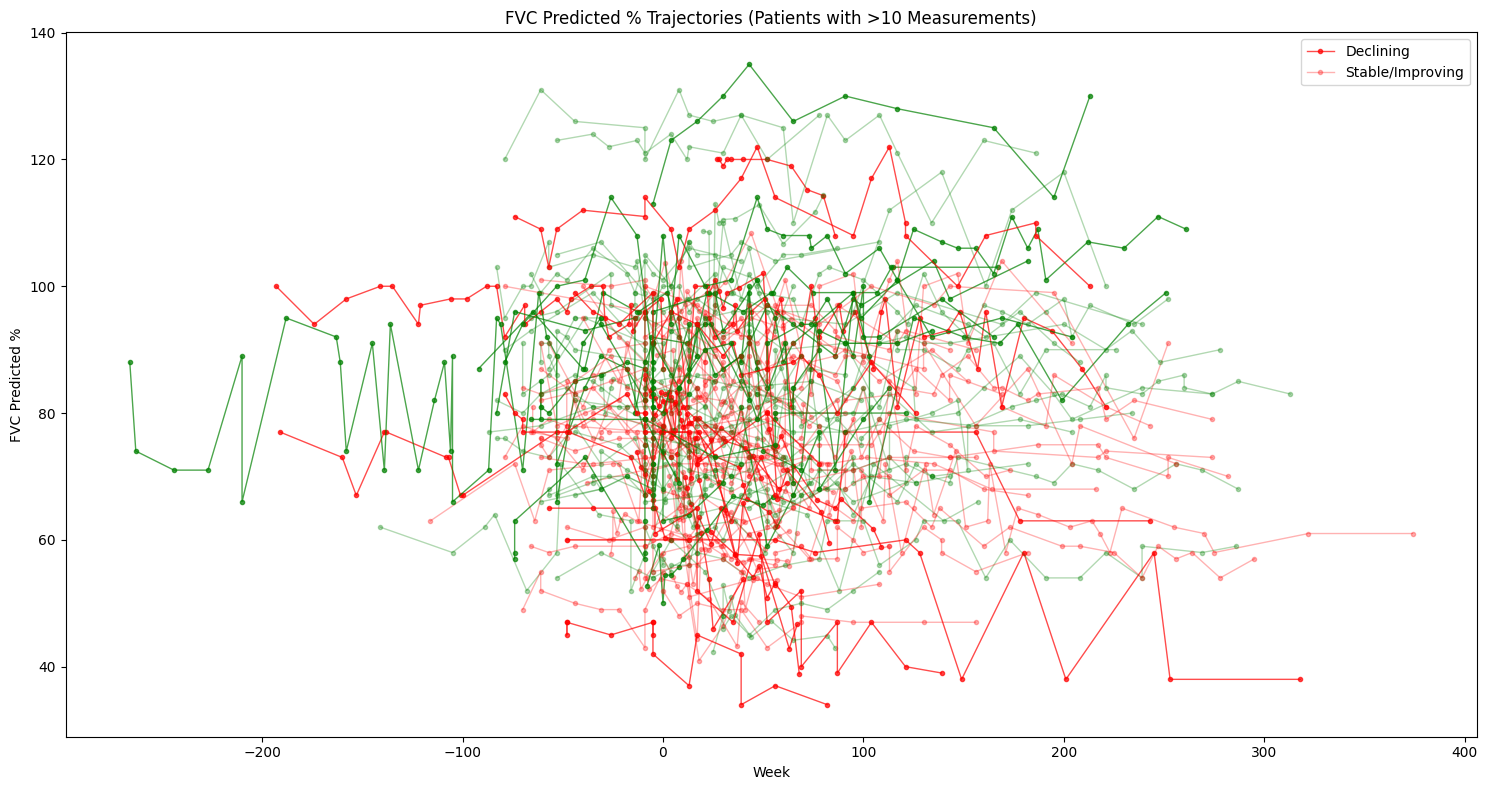

In [15]:
# Visualize FVC trajectories for patients with extensive follow-up
patients_gt10 = df_fvc.groupby('Subject ID').filter(lambda x: len(x) > 10).sort_values(['Subject ID', 'Week'])

plt.figure(figsize=(15, 8))
for subject_id, group in patients_gt10.groupby('Subject ID'):
    group = group.sort_values('Week')
    baseline = group.iloc[0]['FVC Predicted %']
    last = group.iloc[-1]['FVC Predicted %']
    
    # Color code by overall trend
    color = 'red' if last < baseline else 'green'
    alpha = 0.7 if abs(last - baseline) > 10 else 0.3
    
    plt.plot(group['Week'], group['FVC Predicted %'], 
             marker='o', alpha=alpha, color=color, linewidth=1, markersize=3)

plt.title('FVC Predicted % Trajectories (Patients with >10 Measurements)')
plt.xlabel('Week')
plt.ylabel('FVC Predicted %')
plt.legend(['Declining', 'Stable/Improving'], loc='upper right')
plt.tight_layout()
plt.show()

## 6. Data Integration Analysis

### 6.1 CRF and DICOM Date Matching

In [16]:
def convert_dates(dicom_date, fvc_date):
    """Convert dates to comparable formats."""
    try:
        dicom_dt = datetime.strptime(str(int(dicom_date)), "%Y%m%d").date()
        fvc_dt = datetime.strptime(fvc_date.strip("'"), "%Y-%m-%d").date()
        return dicom_dt, fvc_dt
    except:
        return None, None

def analyze_date_overlap(patient_id):
    """Check if DICOM and FVC dates overlap for a patient."""
    try:
        dicom_dates = set()
        fvc_dates = set()
        
        # Get DICOM dates
        for date in merged_df.loc[merged_df['Patient ID'] == patient_id, 'Acquisition Date'].dropna():
            dt, _ = convert_dates(date, "2000-01-01")  # dummy FVC date
            if dt:
                dicom_dates.add(dt)
        
        # Get FVC dates
        for date in concatenated_df.loc[concatenated_df['Subject ID'] == patient_id, 'FVC DATE'].dropna():
            _, dt = convert_dates(20000101, date)  # dummy DICOM date
            if dt:
                fvc_dates.add(dt)
        
        return len(dicom_dates & fvc_dates) > 0
    except:
        return False

# Analyze date overlap
common_patients = set(merged_df['Patient ID']) & set(concatenated_df['Subject ID'])
overlap_count = sum(analyze_date_overlap(pid) for pid in common_patients)

print(f"Patients with both CRF and DICOM data: {len(common_patients)}")
print(f"Patients with matching acquisition/FVC dates: {overlap_count}")
print(f"Date overlap percentage: {overlap_count/len(common_patients)*100:.1f}%")

Patients with both CRF and DICOM data: 3443
Patients with matching acquisition/FVC dates: 1920
Date overlap percentage: 55.8%


## 7. Treatment Analysis

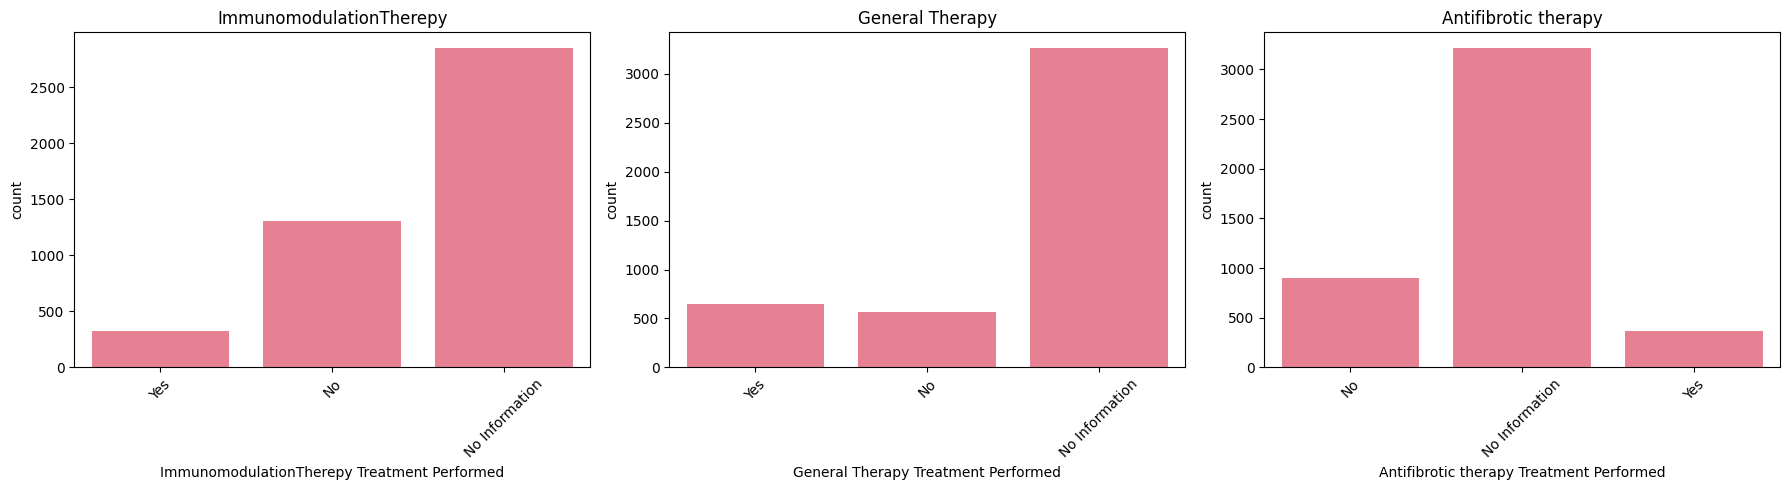

In [17]:
# Analyze treatment patterns
treatment_cols = [
    'ImmunomodulationTherepy Treatment Performed',
    'General Therapy Treatment Performed', 
    'Antifibrotic therapy Treatment Performed'
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(treatment_cols):
    if col in concatenated_df.columns:
        sns.countplot(data=concatenated_df, x=col, ax=axes[i])
        axes[i].set_title(col.replace(' Treatment Performed', ''))
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Follow up Imaging Dependency

  Patients with follow-up imaging: 1,189
Percent of patient with follow up imaging: 34.533836770258496 %


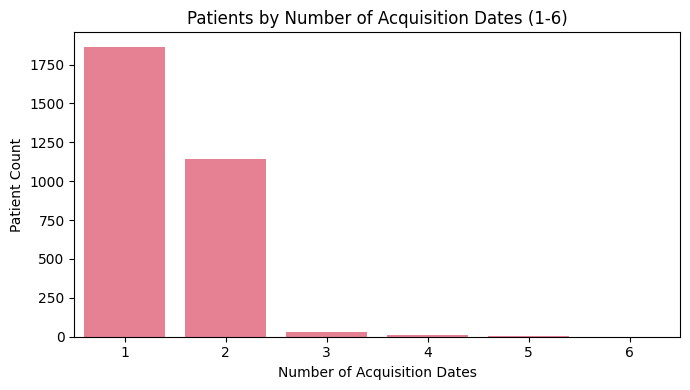

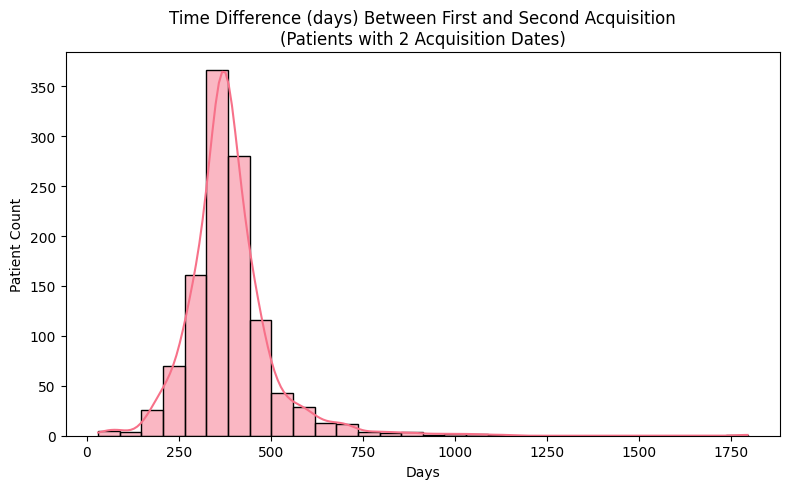

In [36]:
# Patients with follow-up imaging (multiple acquisition dates)
followup_imaging_counts = merged_df.groupby('Patient ID')['Acquisition Date'].nunique()
patients_with_followup_imaging = (followup_imaging_counts > 1).sum()
print(f"  Patients with follow-up imaging: {patients_with_followup_imaging:,}")
print(f"Percent of patient with follow up imaging: {patients_with_followup_imaging/len(set(merged_df['Patient ID']))*100} %")

# Print number of patients with 1,2,3,4,5,6 acquisition dates
acq_counts = [ (followup_imaging_counts == n).sum() for n in range(1, 7) ]
#for n, count in enumerate(acq_counts, start=1):
#    print(f"  Patients with {n} acquisition date(s): {count}")

# Bar plot of patients by number of acquisition dates (1-6)
plt.figure(figsize=(7, 4))
sns.barplot(x=list(range(1, 7)), y=acq_counts)
plt.title('Patients by Number of Acquisition Dates (1-6)')
plt.xlabel('Number of Acquisition Dates')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

patients_2_acq = followup_imaging_counts[followup_imaging_counts == 2].index
time_diffs = []

for pid in patients_2_acq:
    dates = merged_df.loc[merged_df['Patient ID'] == pid, 'Acquisition Date'].dropna().unique()
    if len(dates) == 2:
        try:
            dt1 = datetime.strptime(str(int(dates[0])), "%Y%m%d")
            dt2 = datetime.strptime(str(int(dates[1])), "%Y%m%d")
            diff = abs((dt2 - dt1).days)
            time_diffs.append(diff)
        except Exception:
            continue

plt.figure(figsize=(8, 5))
sns.histplot(time_diffs, bins=30, kde=True)
plt.title('Time Difference (days) Between First and Second Acquisition\n(Patients with 2 Acquisition Dates)')
plt.xlabel('Days')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()


Patient Position Distribution (Follow-up Imaging Patients):
Patient Position
FFS    8661
FFP     547
HFS     461
HFP       2
Name: count, dtype: int64

Patients with same manufacturer across all acquisitions: 937 (78.8%)
Patients with same patient position across all acquisitions: 956 (80.4%)
Patients with both same manufacturer and position: 775 (65.2%)
Patients with both same manufacturer and position (percent over all patients): 775 (22.5%)


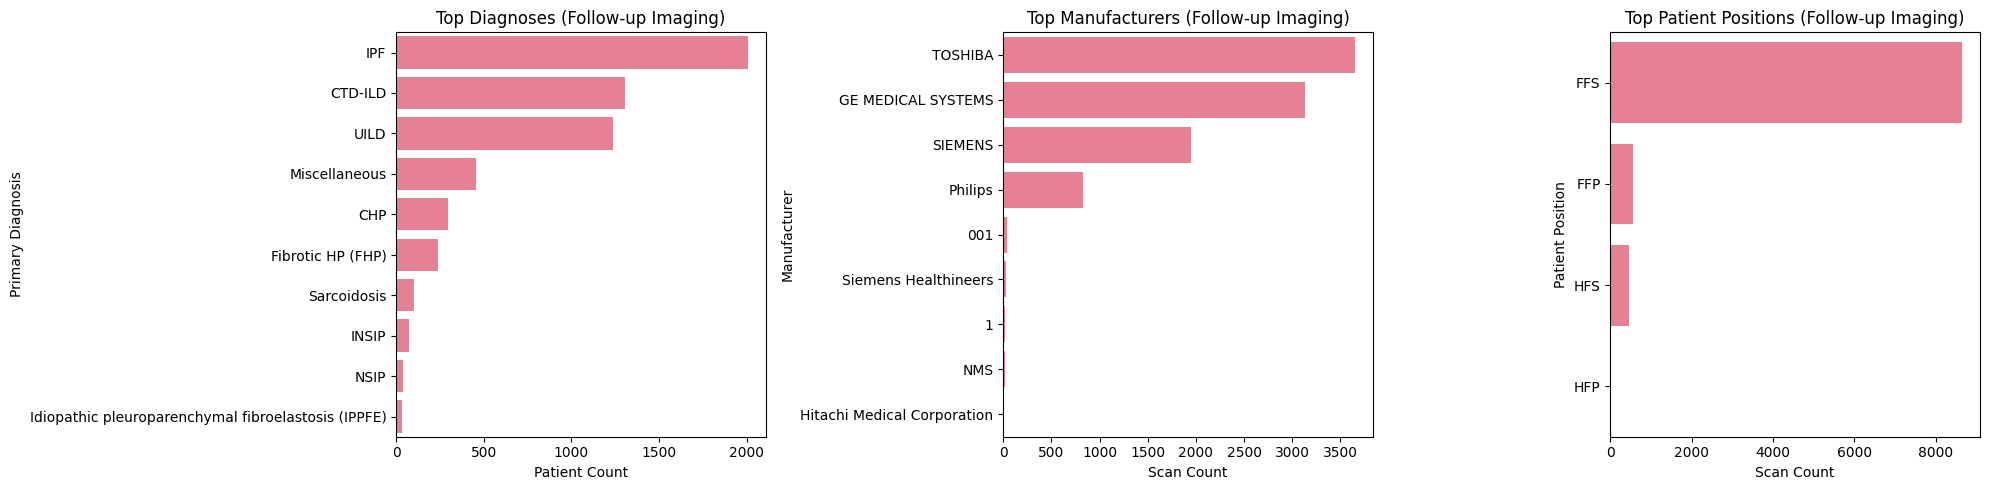

In [32]:
# Statistics for patients with follow-up imaging (more than one acquisition date)
followup_patients = followup_imaging_counts[followup_imaging_counts > 1].index

# Diagnostic distribution
diag_followup = concatenated_df[concatenated_df['Subject ID'].isin(followup_patients)]['Primary Diagnosis'].value_counts()

# Manufacturer distribution
manuf_followup = merged_df[merged_df['Patient ID'].isin(followup_patients)]['Manufacturer'].value_counts()
#
# Patient position distribution (if available)
if 'Patient Position' in merged_df.columns:
    pos_followup = merged_df[merged_df['Patient ID'].isin(followup_patients)]['Patient Position'].value_counts()
    print("\nPatient Position Distribution (Follow-up Imaging Patients):")
    print(pos_followup.head(10))
    # For each patient, check if manufacturer and position stay the same across acquisitions
    same_manuf_count = 0
    same_pos_count = 0
    same_both_count = 0
    for pid in followup_patients:
        subset = merged_df[merged_df['Patient ID'] == pid]
        manuf_unique = subset['Manufacturer'].nunique() == 1
        pos_unique = subset['Patient Position'].nunique() == 1
        if manuf_unique:
            same_manuf_count += 1
        if pos_unique:
            same_pos_count += 1
        if manuf_unique and pos_unique:
            same_both_count += 1

    total_followup = len(followup_patients)
    print(f"\nPatients with same manufacturer across all acquisitions: {same_manuf_count} ({same_manuf_count/total_followup*100:.1f}%)")
    print(f"Patients with same patient position across all acquisitions: {same_pos_count} ({same_pos_count/total_followup*100:.1f}%)")
    print(f"Patients with both same manufacturer and position: {same_both_count} ({same_both_count/total_followup*100:.1f}%)")
    print(f"Patients with both same manufacturer and position (percent over all patients): {same_both_count} ({same_both_count/(len(set(merged_df['Patient ID'])))*100:.1f}%)")

else:
    # Only manufacturer check if position not available
    same_manuf_count = 0
    for pid in followup_patients:
        subset = merged_df[merged_df['Patient ID'] == pid]
        if subset['Manufacturer'].nunique() == 1:
            same_manuf_count += 1
    total_followup = len(followup_patients)
    print(f"\nPatients with same manufacturer across all acquisitions: {same_manuf_count} ({same_manuf_count/total_followup*100:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(x=diag_followup.values[:10], y=diag_followup.index[:10], ax=axes[0])
axes[0].set_title('Top Diagnoses (Follow-up Imaging)')
axes[0].set_xlabel('Patient Count')

sns.barplot(x=manuf_followup.values[:10], y=manuf_followup.index[:10], ax=axes[1])
axes[1].set_title('Top Manufacturers (Follow-up Imaging)')
axes[1].set_xlabel('Scan Count')

if 'Patient Position' in merged_df.columns:
    sns.barplot(x=pos_followup.values[:10], y=pos_followup.index[:10], ax=axes[2])
    axes[2].set_title('Top Patient Positions (Follow-up Imaging)')
    axes[2].set_xlabel('Scan Count')
else:
    axes[2].axis('off')

plt.tight_layout()
plt.show()

## 9. Summary Statistics

In [25]:
# Generate comprehensive summary
print("=== OSIC Dataset Summary ===\n")

print(f"CRF Data:")
print(f"  Total records: {concatenated_df.shape[0]:,}")
print(f"  Unique patients: {concatenated_df['Subject ID'].nunique():,}")
print(f"  Features: {concatenated_df.shape[1]}")

print(f"\nDICOM Data:")
print(f"  Total DICOM files: {merged_df.shape[0]:,}")
print(f"  Unique patients: {merged_df['Patient ID'].nunique():,}")
print(f"  Unique manufacturers: {merged_df['Manufacturer'].nunique()}")

print(f"\nFVC Measurements:")
print(f"  Patients with FVC data: {df_fvc['Subject ID'].nunique():,}")
print(f"  Total FVC measurements: {len(df_fvc):,}")
print(f"  Average measurements per patient: {len(df_fvc)/df_fvc['Subject ID'].nunique():.1f}")

print(f"\nDiagnosis Distribution:")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {count} patients")

=== OSIC Dataset Summary ===

CRF Data:
  Total records: 13,231
  Unique patients: 3,450
  Features: 100

DICOM Data:
  Total DICOM files: 20,867
  Unique patients: 3,443
  Unique manufacturers: 18

FVC Measurements:
  Patients with FVC data: 3,285
  Total FVC measurements: 12,440
  Average measurements per patient: 3.8

Diagnosis Distribution:
  Fibrotic ILD: 2955 patients
  Other/Unclassified: 371 patients
  Inflammatory ILD: 52 patients
  Exposure-Related ILD: 39 patients
  Airway Disease: 29 patients
  Uncategorized: 4 patients


In [19]:
# Reset pandas options
pd.reset_option('all')
print("Analysis complete!")

Analysis complete!


/tmp/ipykernel_2444339/3344675147.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/tmp/ipykernel_2444339/3344675147.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')
